<a href="https://colab.research.google.com/github/slayAlphalu/Knowledge-for-a-data-scientist/blob/master/imbalanced_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
!pip install -q imblearn

In [3]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [4]:
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**Split the dataframe into train, validation, and test**

Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where overfitting is a significant concern from the lack of training data.

In [0]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(raw_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)


In [0]:
# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))


In [15]:

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)


Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)


In [17]:
train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

# Normalize the input features using the sklearn StandardScaler.
# This will set the mean to 0 and standard deviation to 1.
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training features shape: (182276, 30)
Validation features shape: (45569, 30)
Test features shape: (56962, 30)


## Examine the class label imbalance
Let's look at the dataset imbalance: 

In [18]:
neg, pos = np.bincount(train_labels)
total = neg + pos
print('{} positive samples out of {} training samples ({:.2f}% of total)'.format(
    pos, total, 100 * pos / total))

325 positive samples out of 182276 training samples (0.18% of total)


## Define the model and metrics
Define a function that creates a simple neural network with three densely connected hidden layers, an output sigmoid layer that returns the probability of a transaction being fraudulent, and two dropout layers as an effective way to reduce overfitting.**

In [0]:
def make_model():
  model = keras.Sequential([
      keras.layers.Dense(256, activation='relu',
                         input_shape=(train_features.shape[-1],)),
      keras.layers.Dense(256, activation='relu'),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(256, activation='relu'),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(1, activation='sigmoid'),
  ])

  metrics = [
      keras.metrics.Accuracy(name='accuracy'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
  ]

  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=metrics)
  
  return model

## Understanding useful metrics
Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.

**False negatives and false positives** are samples that were incorrectly classified

**True negatives and true positives** are samples that were correctly classified

**Accuracy** is the percentage of examples correctly classified 

**Precision** is the percentage of predicted positives that were correctly classified 

**Recall** is the percentage of actual positives that were correctly classified 

**AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). **This metric is equal to the probability that a classifier will rank a random positive sample higher than than a random negative sample.**


## Train a baseline model
Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, **this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudelent transactions to learn from.**

In [20]:
model = make_model()

EPOCHS = 10
BATCH_SIZE = 2048

history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_features, val_labels))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 182276 samples, validate on 45569 samples
Epoch 1/10
182276/182276 [==============================] - 7s 37us/sample - loss: 0.0305 - accuracy: 0.0216 - tp: 54.0000 - fp: 79.0000 - tn: 181872.0000 - fn: 271.0000 - precision: 0.4060 - recall: 0.1662 - auc: 0.7424 - val_loss: 0.0030 - val_accuracy: 0.0133 - val_tp: 48.0000 - val_fp: 8.0000 - val_tn: 45497.0000 - val_fn: 16.0000 - val_precision: 0.8571 - val_recall: 0.7500 - val_auc: 0.9208
Epoch 2/10
182276/182276 [==============================] - 6s 35us/sample - loss: 0.0039 - accuracy: 0.0157 - tp: 221.0000 - fp: 44.0000 - tn: 181907.0000 - fn: 104.0000 - precision: 0.8340 - recall: 0.6800 - auc: 0.9356 - val_loss: 0.0024 - val_accuracy: 0.0171 - val_tp: 52.0000 - val_fp: 9.0000 - val_tn: 45496.0000 - val_fn: 12.0000

## Plot metrics on the training and validation sets
In this section, you will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting, which you can learn more about in this tutorial.

Additionally, you can produce these plots for any of the metrics you created above. False negatives are included as an example.

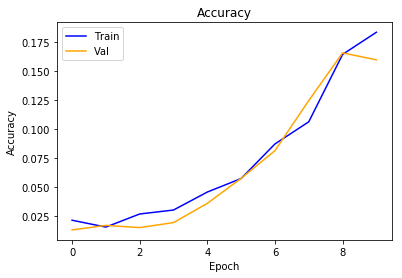

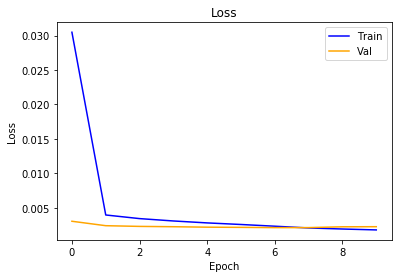

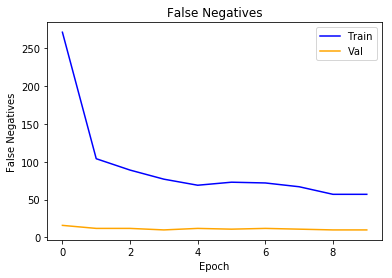

In [21]:
epochs = range(EPOCHS)

plt.title('Accuracy')
plt.plot(epochs,  history.history['accuracy'], color='blue', label='Train')
plt.plot(epochs, history.history['val_accuracy'], color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

_ = plt.figure()
plt.title('Loss')
plt.plot(epochs, history.history['loss'], color='blue', label='Train')
plt.plot(epochs, history.history['val_loss'], color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

_ = plt.figure()
plt.title('False Negatives')
plt.plot(epochs, history.history['fn'], color='blue', label='Train')
plt.plot(epochs, history.history['val_fn'], color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('False Negatives')
plt.legend()

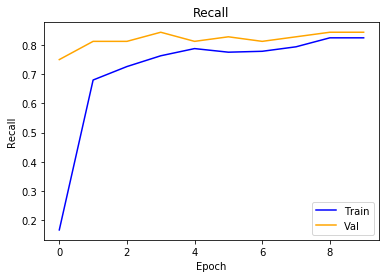

In [22]:
_ = plt.figure()
plt.title('Recall')
plt.plot(epochs, history.history['recall'], color='blue', label='Train')
plt.plot(epochs, history.history['val_recall'], color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

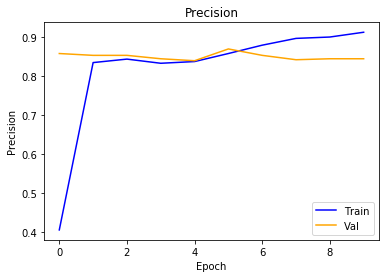

In [23]:
_ = plt.figure()
plt.title('Precision')
plt.plot(epochs, history.history['precision'], color='blue', label='Train')
plt.plot(epochs, history.history['val_precision'], color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

## Evaluate the baseline model

Evaluate your model on the test dataset and display results for the metrics you created above.

In [24]:
results = model.evaluate(test_features, test_labels, verbose=2)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)

56962/56962 - 3s - loss: 0.0039 - accuracy: 0.1614 - tp: 82.0000 - fp: 12.0000 - tn: 56847.0000 - fn: 21.0000 - precision: 0.8723 - recall: 0.7961 - auc: 0.9361
loss :  0.003946262024504068
accuracy :  0.1614234
tp :  82.0
fp :  12.0
tn :  56847.0
fn :  21.0
precision :  0.87234044
recall :  0.79611653
auc :  0.9361114


**It looks like the precision is relatively high, but the recall and AUC aren't as high as you might like.**

Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. **However, because missing fraudulent transactions (false negatives) may have significantly worse business consequences than incorrectly flagging fraudulent transactions (false positives), recall may be more important than precision in this case.**

Examine the confusion matrix
You can use a confusion matrix to summarize the actual vs. predicted labels where the X axis is the predicted label and the Y axis is the actual label

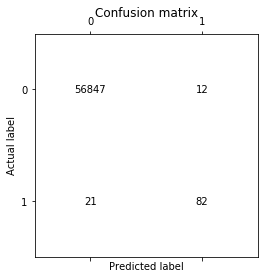

Legitimate Transactions Detected (True Negatives):  56847
Legitimate Transactions Incorrectly Detected (False Positives):  12
Fraudulent Transactions Missed (False Negatives):  21
Fraudulent Transactions Detected (True Positives):  82
Total Fraudulent Transactions:  103


In [25]:
predicted_labels = model.predict(test_features)
cm = confusion_matrix(test_labels, np.round(predicted_labels))

plt.matshow(cm, alpha=0)
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, str(z), ha='center', va='center')
    
plt.show()

print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
print('Total Fraudulent Transactions: ', np.sum(cm[1]))

If the model had predicted everything perfectly, this would be a diagonal matrix where values off the main diagonal, indicating incorrect predictions, would be zero. In this case the matrix shows that you have relatively **few false positives, meaning that there were relatively few legitimate transactions that were incorrectly flagged.** However, you would likely want to have even fewer false negatives despite the cost of increasing the number of false positives. **This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity.**

## Using class weights for the loss function

The goal is to identify fradulent transactions, but you don't have very many of those positive samples to work with, so you would want to **have the classifier heavily weight the few examples that are available**. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [26]:
weight_for_0 = 1 / neg
weight_for_1 = 1 / pos

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2e}'.format(weight_for_0))
print('Weight for class 1: {:.2e}'.format(weight_for_1))

Weight for class 0: 5.50e-06
Weight for class 1: 3.08e-03


## Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Using class_weights changes the range of the loss.**This may affect the stability of the training depending on the optimizer.** Optimizers who's step size is dependent on the magnitude of the gradient, like optimizers.SGD, may fail. **The optimizer used here, optimizers.Adam, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.**

In [27]:
weighted_model = make_model()

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_features, val_labels),
    class_weight=class_weight)

Train on 182276 samples, validate on 45569 samples
Epoch 1/10
182276/182276 [==============================] - 7s 37us/sample - loss: 4.6522e-06 - accuracy: 5.4862e-06 - tp: 293.0000 - fp: 61427.0000 - tn: 120524.0000 - fn: 32.0000 - precision: 0.0047 - recall: 0.9015 - auc: 0.9123 - val_loss: 0.3495 - val_accuracy: 0.0000e+00 - val_tp: 56.0000 - val_fp: 209.0000 - val_tn: 45296.0000 - val_fn: 8.0000 - val_precision: 0.2113 - val_recall: 0.8750 - val_auc: 0.9661
Epoch 2/10
182276/182276 [==============================] - 6s 33us/sample - loss: 2.7319e-06 - accuracy: 2.0299e-04 - tp: 284.0000 - fp: 2824.0000 - tn: 179127.0000 - fn: 41.0000 - precision: 0.0914 - recall: 0.8738 - auc: 0.9556 - val_loss: 0.2053 - val_accuracy: 3.5112e-04 - val_tp: 57.0000 - val_fp: 791.0000 - val_tn: 44714.0000 - val_fn: 7.0000 - val_precision: 0.0672 - val_recall: 0.8906 - val_auc: 0.9756
Epoch 3/10
182276/182276 [==============================] - 6s 32us/sample - loss: 1.8350e-06 - accuracy: 3.7306e-04 -

In [28]:
weighted_results = weighted_model.evaluate(test_features, test_labels, verbose=2)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)

56962/56962 - 3s - loss: 0.0657 - accuracy: 0.0014 - tp: 91.0000 - fp: 1177.0000 - tn: 55682.0000 - fn: 12.0000 - precision: 0.0718 - recall: 0.8835 - auc: 0.9670
loss :  0.06569875825972732
accuracy :  0.0014220006
tp :  91.0
fp :  1177.0
tn :  55682.0
fn :  12.0
precision :  0.07176656
recall :  0.88349515
auc :  0.9670025


Here you can see that with class weights the **accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives.** Despite having lower overall accuracy, this approach may be better when considering the consequences of failing to identify fraudulent transactions **driving the prioritization of recall.** Depending on how bad false negatives are, you might use even more exaggerated weights to further improve recall while dropping precision.

## Oversampling the minority class

A related approach would be to resample the dataset by oversampling the minority class, which is the process of creating more positive samples using something like sklearn's imbalanced-learn library. This library provides methods to create new positive samples by **simply duplicating random existing samples, or by interpolating between them to generate synthetic samples using variations of SMOTE.**TensorFlow also provides a way to do Random Oversampling.

In [29]:
# with default args this will oversample the minority class to have an equal
# number of observations
smote = SMOTE()
res_features, res_labels = smote.fit_sample(train_features, train_labels)

res_neg, res_pos = np.bincount(res_labels)
res_total = res_neg + res_pos
print('{} positive samples out of {} training samples ({:.2f}% of total)'.format(
    res_pos, res_total, 100 * res_pos / res_total))

181951 positive samples out of 363902 training samples (50.00% of total)


## Train and evaluate a model on the resampled data

Now try training the model with the resampled data set instead of using class weights to see how these methods compare.

In [30]:
resampled_model = make_model()

resampled_history = resampled_model.fit(
    res_features,
    res_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_features, val_labels))

Train on 363902 samples, validate on 45569 samples
Epoch 1/10
363902/363902 [==============================] - 12s 33us/sample - loss: 0.0597 - accuracy: 0.2495 - tp: 177814.0000 - fp: 4020.0000 - tn: 177931.0000 - fn: 4137.0000 - precision: 0.9779 - recall: 0.9773 - auc: 0.9978 - val_loss: 0.0102 - val_accuracy: 0.4962 - val_tp: 56.0000 - val_fp: 110.0000 - val_tn: 45395.0000 - val_fn: 8.0000 - val_precision: 0.3373 - val_recall: 0.8750 - val_auc: 0.9513
Epoch 2/10
363902/363902 [==============================] - 11s 31us/sample - loss: 0.0063 - accuracy: 0.5014 - tp: 181906.0000 - fp: 425.0000 - tn: 181526.0000 - fn: 45.0000 - precision: 0.9977 - recall: 0.9998 - auc: 0.9998 - val_loss: 0.0067 - val_accuracy: 0.8231 - val_tp: 55.0000 - val_fp: 54.0000 - val_tn: 45451.0000 - val_fn: 9.0000 - val_precision: 0.5046 - val_recall: 0.8594 - val_auc: 0.9370
Epoch 3/10
363902/363902 [==============================] - 11s 31us/sample - loss: 0.0032 - accuracy: 0.5754 - tp: 181925.0000 - fp: 2

In [31]:
resampled_results = resampled_model.evaluate(test_features, test_labels, verbose=2)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)

56962/56962 - 3s - loss: 0.0155 - accuracy: 0.9837 - tp: 83.0000 - fp: 28.0000 - tn: 56831.0000 - fn: 20.0000 - precision: 0.7477 - recall: 0.8058 - auc: 0.9124
loss :  0.015548273440443744
accuracy :  0.98367333
tp :  83.0
fp :  28.0
tn :  56831.0
fn :  20.0
precision :  0.7477477
recall :  0.80582523
auc :  0.9124037


This approach can be worth trying, but may not provide better results than using class weights because the synthetic examples may not accurately represent the underlying data.

## conclusion
Imbalanced data classification is an inherantly difficult task since there are so few samples to learn from. You should always start with the data first and do your best to collect as many samples as possible and give substantial thought to what features may be relevant so the model can get the most out of your minority class. At some point your model may struggle to improve and yield the results you want, **so it is important to keep in mind the context of the problem to evaluate how bad your false positives or negatives really are.**